In [1]:
import wandb
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
import numpy as np
from torch.utils.data import random_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import scipy.io


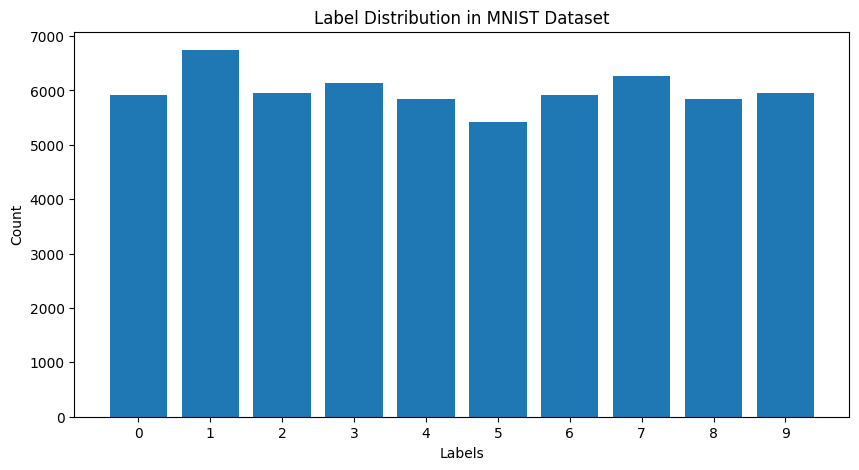

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [2]:
# Define a function to load and visualize the label distribution
def visualize_label_distribution(trainloader):
    label_count = {}
    
    for _, labels in trainloader:
        for label in labels:
            label_count[label.item()] = label_count.get(label.item(), 0) + 1

    labels, counts = zip(*label_count.items())

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.xticks(np.arange(10))
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution in MNIST Dataset')
    plt.show()

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualize the label distribution
visualize_label_distribution(trainloader)
print(trainset)

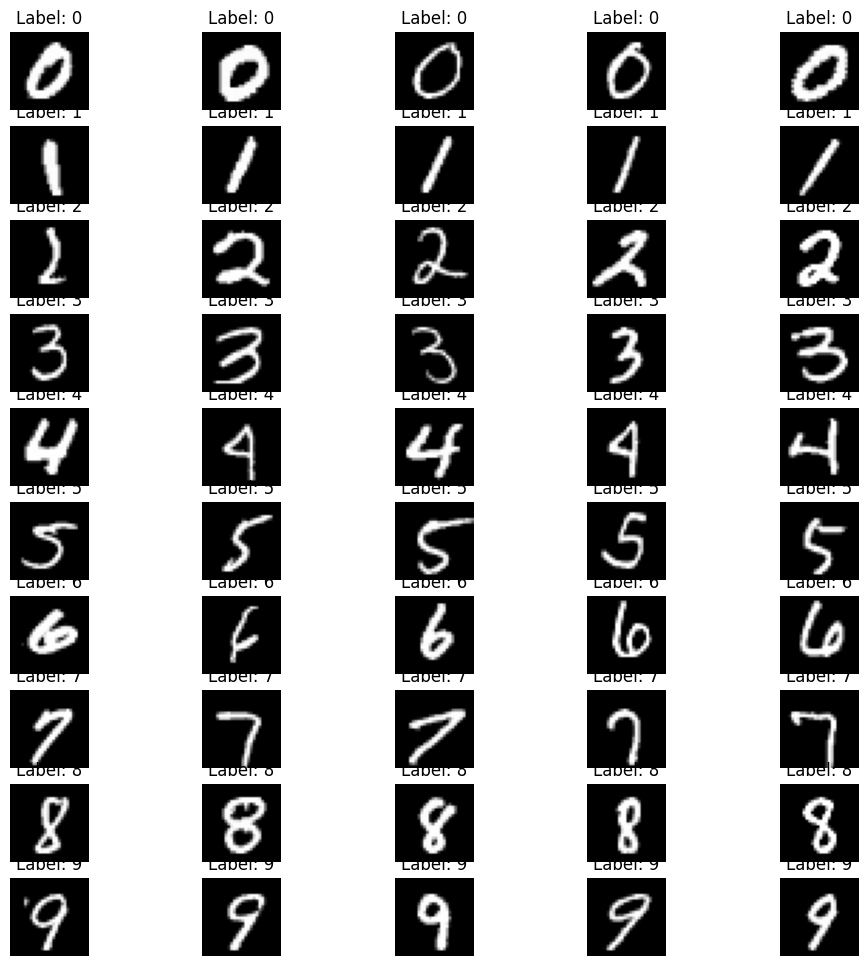

In [3]:
# Define a function to visualize samples from each class
def visualize_samples(trainloader, num_samples=5):
    fig, axes = plt.subplots(10, num_samples, figsize=(12, 12))
    
    sample_images = {}
    for i in range(10):
        sample_images[i] = []

    for images, labels in trainloader:
        for image, label in zip(images, labels):
            if len(sample_images[label.item()]) < num_samples:
                sample_images[label.item()].append(image)

    for i in range(10):
        for j in range(num_samples):
            axes[i, j].imshow(sample_images[i][j][0].numpy(), cmap='gray')
            axes[i, j].set_title(f'Label: {i}')
            axes[i, j].axis('off')

    plt.show()

# Visualize samples from each class
visualize_samples(trainloader, num_samples=5)


In [4]:
from torch.utils.data import random_split

# Define the sizes for train, validation, and test sets
total_size = len(trainset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

# Split the dataset
gen = torch.Generator().manual_seed(42)
train_set, validation_set, test_set = random_split(trainset, [train_size, validation_size, test_size],generator=gen)

# Create data loaders for each set
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


In [12]:
def visualize_feature_maps(model, layer_num, input_image):
    activation = model.features[:layer_num + 1](input_image)
    
    # Select one of the feature maps (channel)
    feature_map = activation[0, 0].detach().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(feature_map, cmap='viridis')
    plt.axis('off')
    plt.title(f'Feature Map for Layer {layer_num}')
    plt.show()



In [12]:
# Define a CNN model
class SimpleCNN(nn.Module):
    def __init__(self, kernel_size=3, pool_size = 2, stride=2, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        var1 = int((28-pool_size)/stride)+1
        self.dim = int((var1-pool_size)/stride)+1
        # print(self.dim)
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # print(self.dim)
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
class SimpleCNNwithoutDropout(nn.Module):
    def __init__(self, kernel_size=3, pool_size = 2, stride=2):
        super(SimpleCNNwithoutDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        var1 = int((28-pool_size)/stride)+1
        self.dim = int((var1-pool_size)/stride)+1
        # print(self.dim)
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        # self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # print(self.dim)
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

netwithoutdropout = SimpleCNNwithoutDropout()
criterion1 = nn.CrossEntropyLoss()
optimizer1 =  optim.Adam(netwithoutdropout.parameters(), lr=0.001)


In [13]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        # outputs = net(inputs)
        # print(outputs)
        outputs = net.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and report the training accuracy and loss
    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")

    # Validate the model on the validation set
    correct = 0
    total = 0
    validation_loss = 0.0
    net.eval()

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            # outputs = net(inputs)
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and report the validation loss and accuracy
    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

# After training, you can also evaluate on the test set if needed
correct = 0
total = 0
test_loss = 0.0
net.eval()
all_predicted = []
all_actual = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted.extend(predicted.tolist())
        all_actual.extend(labels.tolist())

test_loss = test_loss / len(testloader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

confusion_mat = confusion_matrix(all_actual, all_predicted)
print("\nConfusion Matrix:")
print(confusion_mat)

per_class_accuracy = []
for class_label in range(10):  # MNIST dataset has 10 classes
    correct = sum(1 for a, p in zip(all_actual, all_predicted) if a == class_label and p == class_label)
    total = all_actual.count(class_label)
    per_class_accuracy.append(correct / total)
    print(f"Class {class_label} Accuracy: {correct / total:.2f}")

class_names = [str(i) for i in range(10)]
classification_rep = classification_report(all_actual, all_predicted, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)


Epoch 1, Training Loss: 0.2899, Training Accuracy: 91.14%
Epoch 1, Validation Loss: 0.0643, Validation Accuracy: 98.13%
Epoch 2, Training Loss: 0.1020, Training Accuracy: 96.95%
Epoch 2, Validation Loss: 0.0549, Validation Accuracy: 98.52%
Epoch 3, Training Loss: 0.0743, Training Accuracy: 97.79%
Epoch 3, Validation Loss: 0.0487, Validation Accuracy: 98.48%
Epoch 4, Training Loss: 0.0638, Training Accuracy: 98.14%
Epoch 4, Validation Loss: 0.0409, Validation Accuracy: 98.80%
Epoch 5, Training Loss: 0.0533, Training Accuracy: 98.38%
Epoch 5, Validation Loss: 0.0367, Validation Accuracy: 98.97%
Test Loss: 0.0403, Test Accuracy: 98.83%

Confusion Matrix:
[[579   0   1   0   1   0   1   0   1   0]
 [  0 662   1   0   0   0   0   2   1   0]
 [  0   1 567   2   0   0   0   1   3   1]
 [  0   0   4 618   0   0   0   0   0   0]
 [  0   2   1   0 590   0   0   0   0   3]
 [  0   0   0   0   0 512   3   0   2   1]
 [  2   0   2   0   1   2 601   0   2   0]
 [  0   1   3   1   2   0   0 648   1  

In [15]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    netwithoutdropout.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer1.zero_grad()
        outputs = netwithoutdropout(inputs)
        loss = criterion1(outputs, labels)
        loss.backward()
        optimizer1.step()
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and report the training accuracy and loss
    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")

    # Validate the model on the validation set
    correct = 0
    total = 0
    validation_loss = 0.0
    netwithoutdropout.eval()

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            outputs = netwithoutdropout(inputs)
            loss = criterion1(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and report the validation loss and accuracy
    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

# After training, you can also evaluate on the test set if needed
correct = 0
total = 0
test_loss = 0.0
netwithoutdropout.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = netwithoutdropout(inputs)
        loss = criterion1(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and report the test loss and accuracy
test_loss = test_loss / len(testloader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


KeyboardInterrupt: 

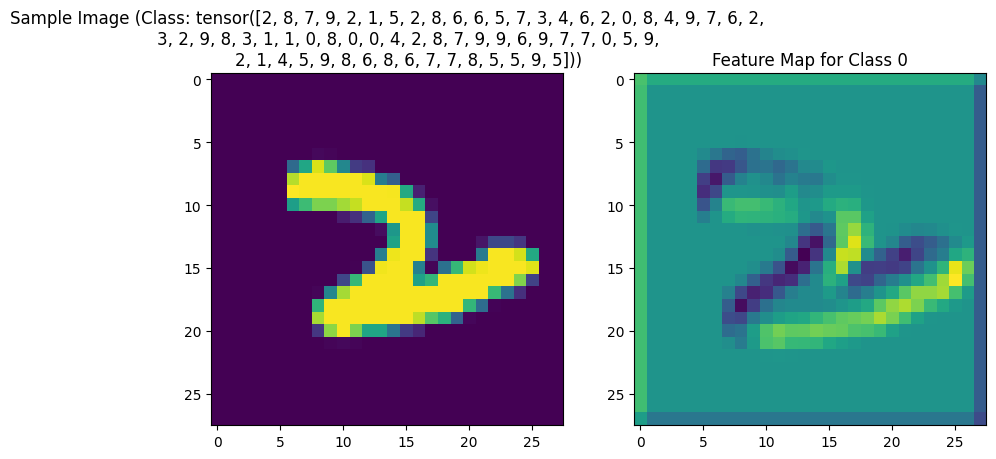

In [ ]:
# Choose a sample image from the dataset
sample_loader = iter(validationloader)
sample_image, sample_label = next(sample_loader)

# Define a function to display feature maps for a specific class
def display_feature_maps(class_id):
    class_output = net(sample_image)
    activation = net.conv1(sample_image)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[0].permute(1, 2, 0).numpy())
    plt.title(f"Sample Image (Class: {sample_label})")
    
    plt.subplot(1, 2, 2)
    plt.imshow(activation[0, class_id].detach().numpy(), cmap='viridis')
    plt.title(f"Feature Map for Class {class_id}")
    plt.show()

# Display feature maps for a specific class (e.g., class_id = 0)
class_id = 0
display_feature_maps(class_id)


In [ ]:
# Initialize W&B
wandb.init(project="mnist_cnn_evaluation")

# Define a configuration for hyperparameter tuning
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 64
wandb.config.kernel_size = 3
wandb.config.stride = 1
wandb.config.epochs = 3
wandb.config.dropout_rate = 0.5

# Create a DataLoader for MNIST
batch_size = wandb.config.batch_size
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
# Create an instance of the SimpleCNN model
net = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=wandb.config.learning_rate)

for epoch in range(wandb.config.epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and log training accuracy
    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct_train / total_train
    wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy})

    # Validation loop (similar to the training loop)
    net.eval()
    correct_val = 0
    total_val = 0
    validation_loss = 0.0
    all_predicted = []
    all_actual = []

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_predicted.extend(predicted.tolist())
            all_actual.extend(labels.tolist())

    # Calculate and log validation accuracy and loss
    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct_val / total_val
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    # Calculate and log confusion matrix and class-specific metrics
    conf_matrix = confusion_matrix(all_actual, all_predicted)
    class_metrics = classification_report(all_actual, all_predicted, target_names=[str(i) for i in range(10)], output_dict=True)
    print(conf_matrix)
    print(class_metrics)
    # wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(conf_matrix, class_names=[str(i) for i in range(10)]),
    #            "class_metrics": class_metrics})

wandb.finish()



In [ ]:


# Define the sweep configuration within the script
sweep_config = {
    "name": "mnist-cnn-hyperparam-tuning",
    "method": "grid",
    "metric": {"goal": "maximize", "name": "val_accuracy"},
    "parameters": {
        "learning_rate": {"values": [0.0001, 0.001]},
        "batch_size": {"values": [64, 128]},
        "kernel_size": {"values": [3, 5]},
        "stride": {"values": [1, 2]},
        "epochs": {"values": [3,5]},
        "dropout_rate": {"values": [0.5, 0.7]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="mnist-cnn-hyperparam-tuning")

# Define the training function
def train():
    # Load hyperparameters for this run
    wandb.init(project="mnist-cnn-hyperparam-tuning")
    config = wandb.config
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    kernel_size = config.kernel_size
    stride = config.stride
    epochs = config.epochs
    dropout_rate = config.dropout_rate

    # Create a DataLoader for MNIST

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=gen)
    validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

    # Create an instance of the SimpleCNN model
    net = SimpleCNN(kernel_size=kernel_size, stride=stride, dropout_rate=dropout_rate)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate and log training accuracy
        training_loss = running_loss / len(trainloader)
        training_accuracy = 100 * correct_train / total_train
        wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy})

        # Validation loop
        net.eval()
        correct_val = 0
        total_val = 0
        validation_loss = 0.0
        all_predicted = []
        all_actual = []

        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_predicted.extend(predicted.tolist())
                all_actual.extend(labels.tolist())

        # Calculate and log validation accuracy and loss
        validation_loss = validation_loss / len(validationloader)
        validation_accuracy = 100 * correct_val / total_val
        print(validation_accuracy)
        wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

# Perform the sweep
wandb.agent(sweep_id, function=train)

# Noisy Dataset

In [3]:
# class SimpleCNN(nn.Module):
#     def __init__(self, kernel_size=3, stride=2, dropout_rate=0.5):
#         super(SimpleCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size = kernel_size, padding=1)
#         self.relu1 = nn.ReLU()
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=stride)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
#         self.relu2 = nn.ReLU()
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=stride)
#         self.fc1 = nn.Linear(64 * 7 * 7, 128)
#         self.relu3 = nn.ReLU()
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = x.view(-1, 1, 28, 28)
#         x = self.pool1(self.relu1(self.conv1(x)))
#         x = self.pool2(self.relu2(self.conv2(x)))
#         x = x.view(-1, 64 * 7 * 7)
#         x = self.relu3(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

class SimpleCNN(nn.Module):
    def __init__(self, kernel_size=5, pool_size = 2, stride=1, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=pool_size, stride=stride)
        var1 = int((28-pool_size)/stride)+1
        self.dim = int((var1-pool_size)/stride)+1
        # print(self.dim)
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        # print(self.dim)
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
mnist_with_awgn = scipy.io.loadmat('mnist-with-awgn.mat')
keys = mnist_with_awgn.keys()
print(keys)
train_data = mnist_with_awgn['train_x']
train_labels = mnist_with_awgn['train_y']
test_data = mnist_with_awgn['test_x']
test_labels = mnist_with_awgn['test_y']
train_data, validation_data, train_labels, validation_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
batch_size = 64
trainset = TensorDataset(torch.Tensor(train_data), torch.Tensor(train_labels))
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

validationset = TensorDataset(torch.Tensor(validation_data), torch.Tensor(validation_labels))
validationloader = DataLoader(validationset, batch_size=batch_size, shuffle=False)

testset = TensorDataset(torch.Tensor(test_data), torch.Tensor(test_labels))
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(train_data.shape)

dict_keys(['__header__', '__version__', '__globals__', 'train_x', 'test_x', 'train_y', 'test_y'])
(48000, 784)


In [6]:
# Create DataLoader instances for the training and test datasets

# Define the model
net = SimpleCNN(kernel_size=3, stride=2, dropout_rate=0.5)  # Adjust the model architecture as needed
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

num_epochs = 5  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
    validation_accuracy /= num_validation_samples
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Train Accuracy: {validation_accuracy * 100:.2f}%")
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()

    for i, data in enumerate(validationloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
    validation_accuracy /= num_validation_samples
    print(f"Epoch {epoch + 1}, Validation Loss: {running_loss / len(trainloader)}, Validation Accuracy: {validation_accuracy * 100:.2f}%")
    
for epoch in range(num_epochs):
    running_loss = 0.0
    validation_accuracy = 0.0
    num_validation_samples = 0.0
    net.train()
    true_classes_ = []
    predicted_ = []
    for i, data in enumerate(testloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        # total += labels.size(0)
        true_classes = torch.argmax(labels, dim=1)
        # print(true_classes.tolist())
        # print(labels.tolist())
        # print(predicted.tolist())
        validation_accuracy += accuracy_score(true_classes.tolist(), predicted.tolist()) * len(labels)
        num_validation_samples += len(labels)
        running_loss += loss.item()
        true_classes_.extend(true_classes.tolist())
        predicted_.extend(predicted.tolist())
    validation_accuracy /= num_validation_samples
    print("\nClassification Report:")
    print(classification_report(true_classes_, predicted_))
    print(f"Epoch {epoch + 1}, Testing Loss: {running_loss / len(trainloader)}, Testing Accuracy: {validation_accuracy * 100:.2f}%")


Epoch 1, Training Loss: 0.7163683706323306, Train Accuracy: 82.37%
Epoch 1, Validation Loss: 0.07817426292101542, Validation Accuracy: 90.72%
Epoch 2, Training Loss: 0.26836344617108504, Train Accuracy: 91.66%
Epoch 2, Validation Loss: 0.06230332141121229, Validation Accuracy: 92.58%
Epoch 3, Training Loss: 0.22355730905135474, Train Accuracy: 93.06%
Epoch 3, Validation Loss: 0.05214484068751335, Validation Accuracy: 93.62%
Epoch 4, Training Loss: 0.2038469968289137, Train Accuracy: 93.74%
Epoch 4, Validation Loss: 0.04799090188244979, Validation Accuracy: 94.08%
Epoch 5, Training Loss: 0.1869555188640952, Train Accuracy: 94.24%
Epoch 5, Validation Loss: 0.04479141534864903, Validation Accuracy: 94.74%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.94      0.94      0.94      1032
           3       0.95      0.94      0.94    